In [7]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

[*********************100%***********************]  1 of 1 completed


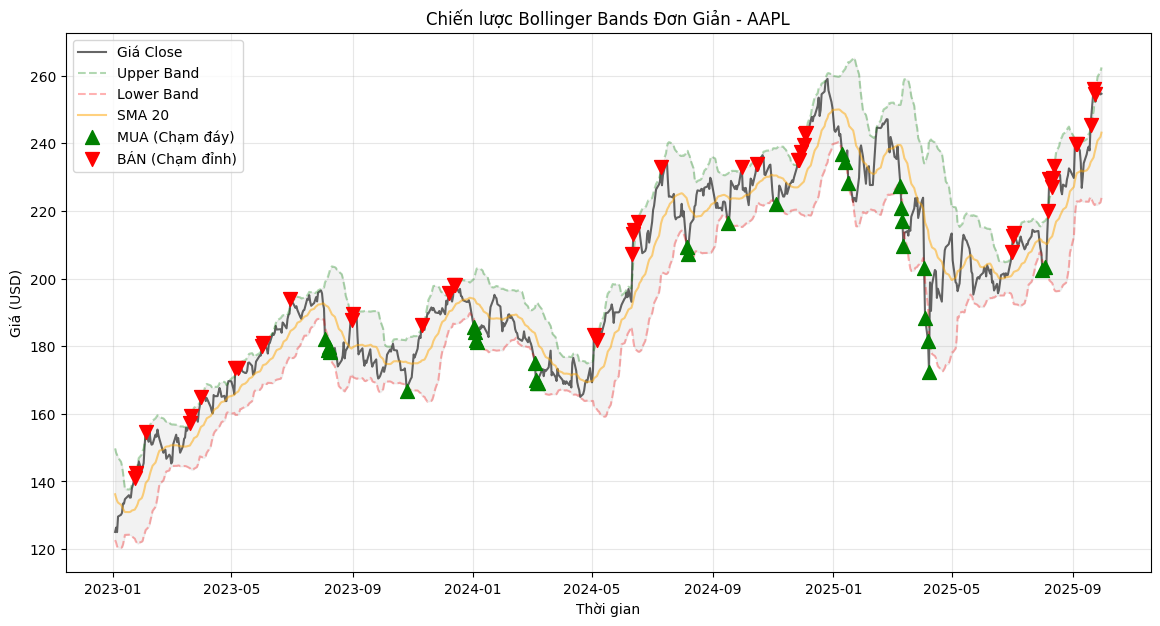

In [8]:
# 1. TẢI DỮ LIỆU
data = yf.download('AAPL', start='2015-01-01', end='2025-10-01', auto_adjust=False)

# Xử lý lỗi MultiIndex (do phiên bản yfinance mới thường trả về dạng cột lồng nhau)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# 2. TÍNH TOÁN BOLLINGER BANDS
window = 20
std_dev = 2

#  (SMA 20)
data['Middle Band'] = data['Close'].rolling(window=window).mean()
# Độ lệch chuẩn
data['Std'] = data['Close'].rolling(window=window).std()
# Dải trên và Dải dưới
data['Upper Band'] = data['Middle Band'] + (data['Std'] * std_dev)
data['Lower Band'] = data['Middle Band'] - (data['Std'] * std_dev)

# 3. XÂY DỰNG TÍN HIỆU GIAO DỊCH (Mean Reversion)
# Mua khi giá đóng cửa < Dải dưới
# Bán khi giá đóng cửa > Dải trên

data['Buy_Signal'] = np.where(data['Close'] < data['Lower Band'], data['Close'], np.nan)
data['Sell_Signal'] = np.where(data['Close'] > data['Upper Band'], data['Close'], np.nan)

# Lọc bớt tín hiệu để biểu đồ đỡ rối (chỉ lấy 1 năm cuối để xem cho rõ)
subset = data.loc['2023-01-01':]

# 4. VẼ BIỂU ĐỒ (VISUALIZATION)
plt.figure(figsize=(14, 7))

# Vẽ giá và các đường Bands
plt.plot(subset.index, subset['Close'], label='Giá Close', color='black', alpha=0.6)
plt.plot(subset.index, subset['Upper Band'], label='Upper Band', color='green', alpha=0.3, linestyle='--')
plt.plot(subset.index, subset['Lower Band'], label='Lower Band', color='red', alpha=0.3, linestyle='--')
plt.plot(subset.index, subset['Middle Band'], label='SMA 20', color='orange', alpha=0.5)

# Tô màu nền giữa 2 dải (Mây Bollinger)
plt.fill_between(subset.index, subset['Upper Band'], subset['Lower Band'], color='gray', alpha=0.1)

# Vẽ mũi tên Mua/Bán
plt.scatter(subset.index, subset['Buy_Signal'], label='MUA (Chạm đáy)', marker='^', color='green', s=100, zorder=5)
plt.scatter(subset.index, subset['Sell_Signal'], label='BÁN (Chạm đỉnh)', marker='v', color='red', s=100, zorder=5)

plt.title('Chiến lược Bollinger Bands Đơn Giản - AAPL')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USD)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.show()

Chiến lược: Trend Following
- Mua vào: Khi giá đóng cửa cắt lên trên Đường giữa
- Giữ lệnh: Kệ cho giá chạm Dải trên (Upper Band). Càng chạm dải trên càng tốt (thể hiện lực tăng mạnh). Không bán!
- Bán ra (Thoát lệnh): Chỉ bán khi giá quay đầu cắt xuống dưới Đường giữa (Middle Band).

So sánh nó với chiến lược "Buy & Hold" (Mua năm 2015 và giữ nguyên đến nay).

[*********************100%***********************]  1 of 1 completed


--- KẾT QUẢ BACKTEST (2015 - Nay) ---
Vốn ban đầu: $10000
1. Chiến lược Buy & Hold (Cứ mua để đó): $104954.25 (Lãi 949.54%)
2. Chiến lược Bollinger Bands:            $83500.14 (Lãi 735.00%)


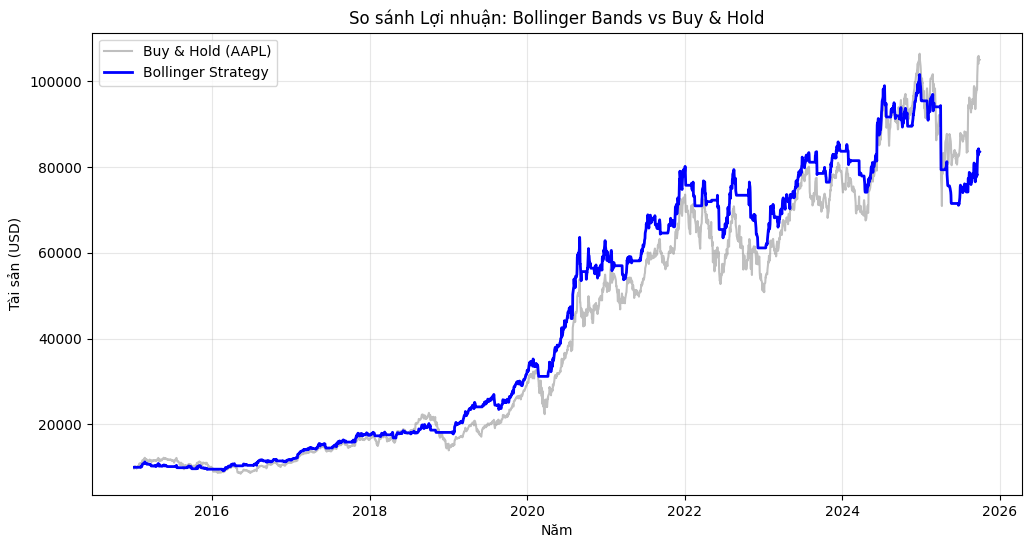

In [9]:

# 1. TẢI DỮ LIỆU
data = yf.download('AAPL', start='2015-01-01', end='2025-10-01', auto_adjust=False)

# Xử lý MultiIndex nếu có
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# 2. TÍNH TOÁN BOLLINGER BANDS
window = 20
std_dev = 2

data['Middle Band'] = data['Adj Close'].rolling(window=window).mean()
data['Std'] = data['Adj Close'].rolling(window=window).std()
data['Upper Band'] = data['Middle Band'] + (data['Std'] * std_dev)
data['Lower Band'] = data['Middle Band'] - (data['Std'] * std_dev)

# 3. LOGIC BACKTEST (LONG ONLY)
# 3. LOGIC BACKTEST (TREND FOLLOWING)

# Khởi tạo cột Signal bằng 0 hết
data['Signal'] = 0

# MUA: Vẫn giữ nguyên (Mua khi giá rẻ - chạm dải dưới)
# Mua khi giá đóng cửa > Middle Band (Bắt đầu xu hướng tăng)
data.loc[data['Adj Close'] > data['Middle Band'], 'Signal'] = 1

# BÁN: Chỉ bán khi giá gãy xuống dưới Lower Band (Hoặc đường nào đó thấp hơn)
# Để đơn giản, ta giữ lệnh luôn (Signal = 1) chừng nào giá chưa gãy đường MA50 (Ví dụ)
# Nhưng để dùng lại các biến có sẵn, ta sẽ BÁN khi giá thủng Middle Band
data.loc[data['Adj Close'] < data['Middle Band'], 'Signal'] = 0

# --- QUAN TRỌNG: XỬ LÝ VỊ THẾ GIỮ LỆNH ---
# Logic trên là dạng từng điểm rời rạc. Để backtest đúng, ta cần vòng lặp hoặc logic ffill
# Cách đơn giản nhất cho người mới (Logic thô):
# Nếu Close > Middle Band -> Giữ lệnh (1)
# Nếu Close < Middle Band -> Cầm tiền (0)

data['Signal'] = np.where(data['Adj Close'] > data['Middle Band'], 1, 0)

# Dời tín hiệu đi 1 ngày (Mua bán vào giá mở cửa hôm sau)
data['Signal'] = data['Signal'].shift(1)
# 4. TÍNH TOÁN LỢI NHUẬN
# Tính % thay đổi giá hàng ngày
data['Market_Returns'] = data['Adj Close'].pct_change()

# Tính lợi nhuận chiến lược
# Dùng shift(1) để tránh "nhìn trước tương lai". Tín hiệu hôm nay dùng để giao dịch ngày mai.
data['Strategy_Returns'] = data['Market_Returns'] * data['Signal'].shift(1)

# Giả lập vốn 10,000 USD
initial_capital = 10000
data['Buy_Hold_Equity'] = initial_capital * (1 + data['Market_Returns']).cumprod()
data['Strategy_Equity'] = initial_capital * (1 + data['Strategy_Returns']).cumprod()

# 5. ĐÁNH GIÁ HIỆU QUẢ
total_return_str = (data['Strategy_Equity'].iloc[-1] / initial_capital - 1) * 100
total_return_bh = (data['Buy_Hold_Equity'].iloc[-1] / initial_capital - 1) * 100

print(f"--- KẾT QUẢ BACKTEST (2015 - Nay) ---")
print(f"Vốn ban đầu: ${initial_capital}")
print(f"1. Chiến lược Buy & Hold (Cứ mua để đó): ${data['Buy_Hold_Equity'].iloc[-1]:.2f} (Lãi {total_return_bh:.2f}%)")
print(f"2. Chiến lược Bollinger Bands:            ${data['Strategy_Equity'].iloc[-1]:.2f} (Lãi {total_return_str:.2f}%)")

# 6. VẼ BIỂU ĐỒ SO SÁNH
plt.figure(figsize=(12, 6))
plt.plot(data['Buy_Hold_Equity'], label='Buy & Hold (AAPL)', color='gray', alpha=0.5)
plt.plot(data['Strategy_Equity'], label='Bollinger Strategy', color='blue', linewidth=2)
plt.title('So sánh Lợi nhuận: Bollinger Bands vs Buy & Hold')
plt.xlabel('Năm')
plt.ylabel('Tài sản (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
! git add .
! git commit -m "Update Bollinger Bands"
! git push


fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


Thêm phần làm đẹp data và xuất plot

[*********************100%***********************]  1 of 1 completed


Số ngày bị làm đầy dữ liệu: 0


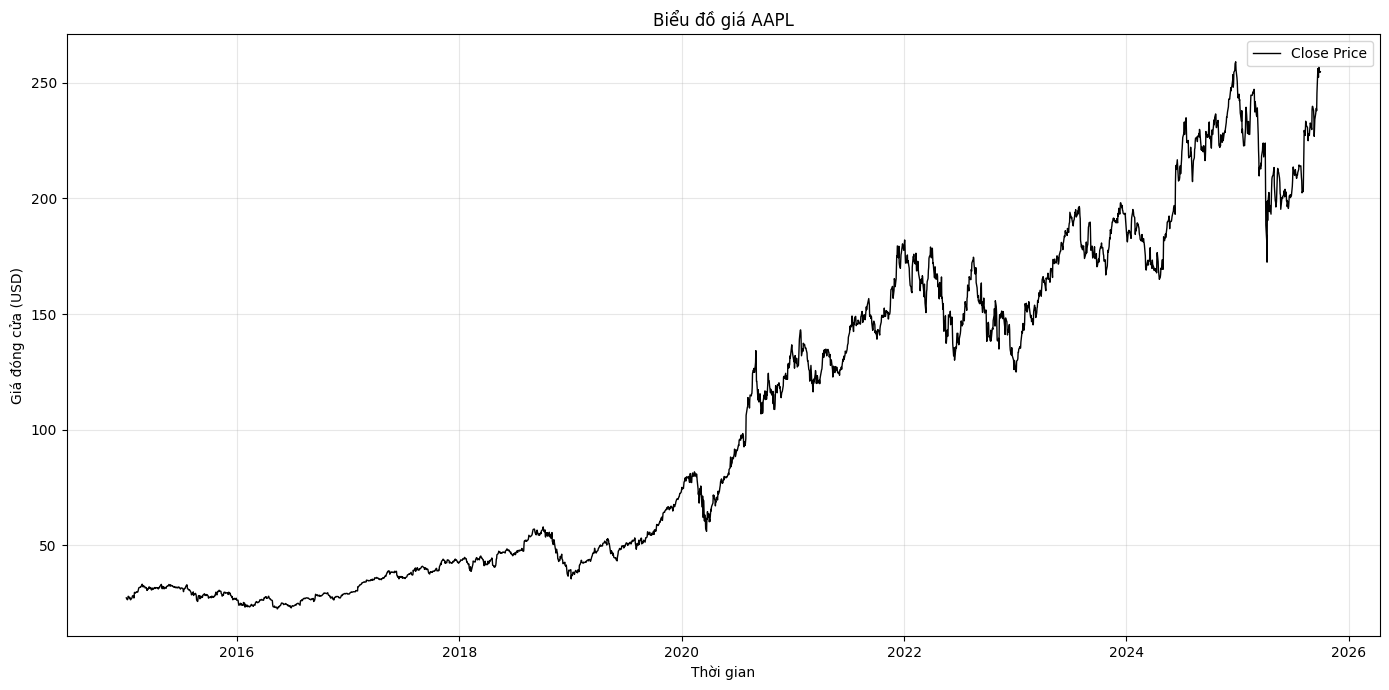

In [14]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# =========================
# 1. TẢI DỮ LIỆU
# =========================
data = yf.download('AAPL', start='2015-01-01', end='2025-10-01', auto_adjust=False)

# Xử lý MultiIndex (nếu có)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# =========================
# 2. LÀM ĐẦY (IMPUTE) CÁC GIÁ TRỐNG
# =========================

price_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close']

# Đánh dấu NaN ban đầu
for c in price_cols + ['Volume']:
    data[f'{c}_wasna'] = data[c].isna()

# Fill giá
data[price_cols] = data[price_cols].ffill().bfill()

# Volume: ffill → fillna(0)
data['Volume'] = data['Volume'].ffill().fillna(0)

# Interpolate dự phòng
num_cols = data.select_dtypes(include=[np.number]).columns
data[num_cols] = data[num_cols].interpolate(method='time', limit_direction='both')

# Flag ngày bị impute
wasna_cols = [f'{c}_wasna' for c in price_cols + ['Volume']]
data['any_imputed'] = data[wasna_cols].any(axis=1)

print("Số ngày bị làm đầy dữ liệu:", data['any_imputed'].sum())

# =========================
# 3. GIỚI HẠN DỮ LIỆU ĐẾN 2025-10-01
# =========================
subset = data.loc['2015-01-01':'2025-10-01']

# =========================
# 4. VẼ BIỂU ĐỒ GIÁ
# =========================
plt.figure(figsize=(14, 7))
plt.plot(subset.index, subset['Close'], color='black', linewidth=1, label='Close Price')

# Hiển thị điểm đã impute (vàng)
imp_dates = subset.index[subset['any_imputed']]
if len(imp_dates) > 0:
    plt.scatter(imp_dates,
                subset.loc[imp_dates, 'Close'],
                color='gold', edgecolors='black',
                label='Imputed values', s=40, zorder=6)

plt.title("Biểu đồ giá AAPL")
plt.xlabel("Thời gian")
plt.ylabel("Giá đóng cửa (USD)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
